![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [55]:
# For data management
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv

#For Portfolo Optimization
import numpy as np
import pandas as pd
import hvplot.pandas  
from scipy.optimize import minimize, Bounds

#For Simulation
from MCForecastTools import MCSimulation

load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [56]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [57]:
# Get porfolio and report data from user
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

portfolio_df = pd.read_sql_query("SELECT * FROM portfolio", engine)

report_df = pd.read_sql_query("SELECT * FROM report", engine)
[risk_tolerance, years_until_retirement] = report_df.iloc[0]

portfolio_df

,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,500.0,Equity
3,XLB,1000.0,Equity


In [58]:
print(f"My risk level is {risk_tolerance}.")
print(f"I plan on retiring in {years_until_retirement} years.")

My risk level is high.
I plan on retiring in 20.0 years.


In [59]:
#CHANGE IN INITIAL POSITION
new_quantities=pd.DataFrame({'quantity':[10,20,500,1000]})
new_quantities
portfolio_df.update(new_quantities)
portfolio_df


,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,500.0,Equity
3,XLB,1000.0,Equity


In [60]:
#ADDED PAOLA
# Tickers for portfolio and recommendation
etf_addition_for_diversification=pd.DataFrame([{"symbol":"SPY", "quantity":0, "type":"Equity"},{"symbol":"AGG", "quantity":0, "type":"Fixed Income"}])
etf_addition_for_diversification

,symbol,quantity,type
0,SPY,0,Equity
1,AGG,0,Fixed Income


In [61]:
#ADDED PAOLA
# Portfolio extended for recommendation based on risk profile
portfolio_extended_df=pd.concat([portfolio_df, etf_addition_for_diversification], axis=0)
portfolio_extended_df["Equity"]=portfolio_extended_df["type"]=="Equity"
portfolio_extended_df["Fixed Income"]=portfolio_extended_df["type"]=="Fixed Income"
portfolio_extended_df=portfolio_extended_df.sort_values("symbol",ignore_index=True)
portfolio_extended_df

,symbol,quantity,type,Equity,Fixed Income
0,AGG,0.0,Fixed Income,False,True
1,CMG,20.0,Equity,True,False
2,GOOG,10.0,Equity,True,False
3,IBM,500.0,Equity,True,False
4,SPY,0.0,Equity,True,False
5,XLB,1000.0,Equity,True,False


In [62]:
#ADDED PAOLA
# Tickers preparation for ALPACA
tickers=portfolio_extended_df["symbol"]
tickers=tickers.drop_duplicates()
tickers

0     AGG
1     CMG
2    GOOG
3     IBM
4     SPY
5     XLB
Name: symbol, dtype: object

In [63]:
# Set the tickers
#tickers = portfolio_df["symbol"]

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

# Fetch batches of data from alpaca api to get as miuch hostorical data as possible (up to num_years)
batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

# empty DF to hold alpaca data
all_results_df = pd.DataFrame()


next_batch_date = first_date
while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df
    
    results_batch_df.drop(['open', 'high', 'low', 'volume'], level=1, axis=1, inplace=True)

    all_results_df = pd.concat([all_results_df, results_batch_df])
    num_days_data_needed -= batch_size

all_results_df.sort_index(inplace=True)

# Display data
all_results_df

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.65,146.68,342.59,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.72,141.46,342.49,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.12,127.12,328.48,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.26,123.61,324.34,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.51,117.77,315.66,97.39,138.81,39.60
...,...,...,...,...,...,...
2021-08-12 00:00:00-04:00,115.54,1875.99,2767.78,143.07,445.08,86.37
2021-08-13 00:00:00-04:00,115.97,1888.44,2769.18,143.20,445.90,86.45


In [77]:
# ORIGINAL PORTFOLIO
last_price = []
for t in portfolio_df['symbol']:
    last_price.append(all_results_df[t]['close'][-1])

portfolio_df['price'] = last_price
portfolio_df['total'] = portfolio_df['price'] * portfolio_df['quantity']
total_portfolio_value = portfolio_df['total'].sum()


portfolio_df['weight'] = portfolio_df['total'] / total_portfolio_value
display(portfolio_df)
print(f"Total portfolio valus is ${total_portfolio_value:,.2f}")

,symbol,quantity,type,price,total,weight
0,GOOG,10.0,Equity,2731.39,27313.9,0.125242
1,CMG,20.0,Equity,1850.26,37005.2,0.169679
2,IBM,500.0,Equity,139.46,69730.0,0.319732
3,XLB,1000.0,Equity,84.04,84040.0,0.385347


Total portfolio valus is $218,089.10


In [65]:
# ADDED PAOLA -- THIS FUNCTION WE CAN SET APART AND REUSED TO VALUE PORTFOLIOS
# Extended portfolio
last_price = []
for t in portfolio_extended_df['symbol']:
    last_price.append(all_results_df[t]['close'][-1])

portfolio_extended_df['price'] = last_price
portfolio_extended_df['total'] = portfolio_extended_df['price'] * portfolio_extended_df['quantity']
total_portfolio_extended_value = portfolio_extended_df['total'].sum()


display(portfolio_extended_df)
print(f"Total portfolio valus is ${total_portfolio_extended_value:,.2f}")


,symbol,quantity,type,Equity,Fixed Income,price,total
0,AGG,0.0,Fixed Income,False,True,115.96,0.0
1,CMG,20.0,Equity,True,False,1850.26,37005.2
2,GOOG,10.0,Equity,True,False,2731.39,27313.9
3,IBM,500.0,Equity,True,False,139.46,69730.0
4,SPY,0.0,Equity,True,False,439.21,0.0
5,XLB,1000.0,Equity,True,False,84.04,84040.0


Total portfolio valus is $218,089.10


In [66]:
# Allocation column
portfolio_extended_df['Original Allocation'] = portfolio_extended_df['total'] /portfolio_extended_df['total'].sum()
portfolio_extended_df

,symbol,quantity,type,Equity,Fixed Income,price,total,Original Allocation
0,AGG,0.0,Fixed Income,False,True,115.96,0.0,0.000000
1,CMG,20.0,Equity,True,False,1850.26,37005.2,0.169679
2,GOOG,10.0,Equity,True,False,2731.39,27313.9,0.125242
3,IBM,500.0,Equity,True,False,139.46,69730.0,0.319732
4,SPY,0.0,Equity,True,False,439.21,0.0,0.000000
5,XLB,1000.0,Equity,True,False,84.04,84040.0,0.385347


<AxesSubplot:xlabel='time'>

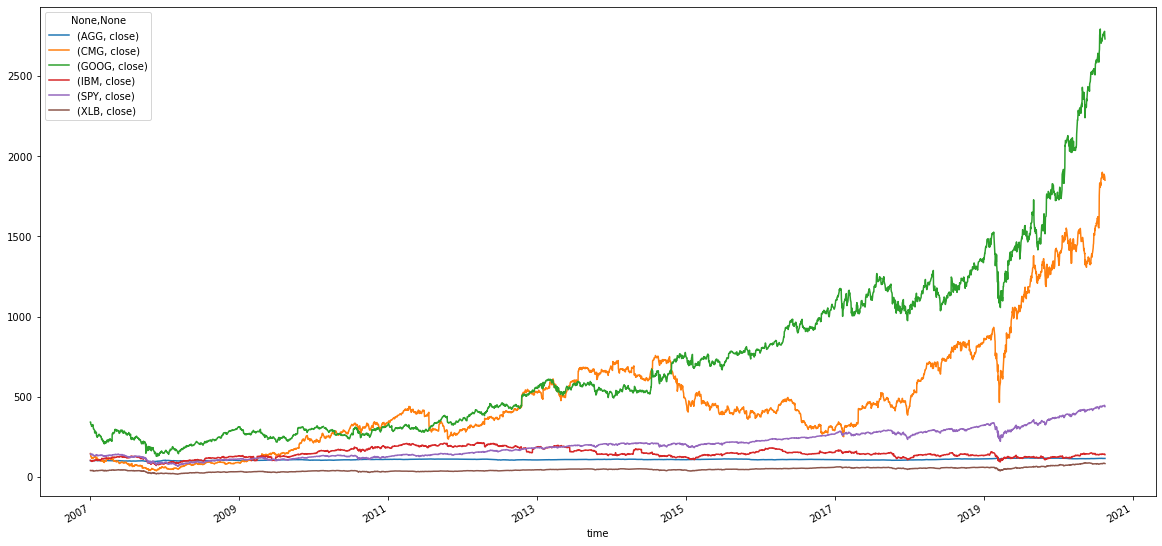

In [67]:
all_close_df = all_results_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10])

In [68]:
print("Current portfolio expected return")
print("Current portfolio volatility")
print("Current portfolio sharpe ratio")

Current portfolio expected return
Current portfolio volatility
Current portfolio sharpe ratio


---

# Metrics of the portfolio
Daily returns, correlation, covariance



In [69]:
portfolio_prices = all_results_df

In [70]:
portfolio_prices.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
,close,close,close,close,close,close
time,,,,,,
2008-01-02 00:00:00-05:00,101.65,146.68,342.59,104.79,144.55,41.33
2008-01-03 00:00:00-05:00,101.72,141.46,342.49,104.94,144.46,41.80
2008-01-04 00:00:00-05:00,102.12,127.12,328.48,101.11,140.93,40.74
2008-01-07 00:00:00-05:00,102.26,123.61,324.34,100.14,141.46,40.25
2008-01-08 00:00:00-05:00,102.51,117.77,315.66,97.39,138.81,39.60


In [71]:
portfolio_daily_returns = portfolio_prices.pct_change(1).dropna()
portfolio_daily_returns.columns = portfolio_daily_returns.columns.droplevel(1)
portfolio_daily_returns.head()

,AGG,CMG,GOOG,IBM,SPY,XLB
time,,,,,,
2008-01-03 00:00:00-05:00,0.000689,-0.035588,-0.000292,0.001431,-0.000623,0.011372
2008-01-04 00:00:00-05:00,0.003932,-0.101371,-0.040906,-0.036497,-0.024436,-0.025359
2008-01-07 00:00:00-05:00,0.001371,-0.027612,-0.012604,-0.009594,0.003761,-0.012027
2008-01-08 00:00:00-05:00,0.002445,-0.047245,-0.026762,-0.027462,-0.018733,-0.016149
2008-01-09 00:00:00-05:00,-0.002927,0.007897,0.033866,0.009652,0.014192,0.009343


In [72]:
# Calculates correlation of securities in the client_portfolio_prices
print("        Correlations Among Assets")
round(portfolio_daily_returns.corr(),2)

        Correlations Among Assets


,AGG,CMG,GOOG,IBM,SPY,XLB
AGG,1.00,-0.01,-0.02,-0.04,-0.08,-0.08
CMG,-0.01,1.00,0.35,0.22,0.46,0.40
GOOG,-0.02,0.35,1.00,0.34,0.62,0.52
IBM,-0.04,0.22,0.34,1.00,0.56,0.51
SPY,-0.08,0.46,0.62,0.56,1.00,0.89
XLB,-0.08,0.40,0.52,0.51,0.89,1.00


# Portfolio Optimization and Recommendation

Optimizes the Sharpe Ratio of a portfolio based on the risk profile of the user.

Level of risk:
1. Aggressive 
2. Moderate
3. Conservative

Use as base a code on: https://examples.pyviz.org/portfolio_optimizer/portfolio.html#portfolio-optimizer-gallery-portfolio
But here we will not use log returns, and we will add two constraints for the portfolio asset allocation based on the risk profile

In [73]:
# set level of risk according to risk profile
level_of_risk=1

In [74]:
#Number of instruments and asset classes
n=len(portfolio_prices.columns)
portfolio_extended_df=portfolio_extended_df.set_index('symbol')

In [75]:
asset_class_securities=pd.DataFrame({"Equity": np.nan, "Fixed Income":np.nan }, index=portfolio_extended_df.index)
asset_class_securities['Equity']=portfolio_extended_df["Equity"]
portfolio_extended_df

,quantity,type,Equity,Fixed Income,price,total,Original Allocation
symbol,,,,,,,
AGG,0.0,Fixed Income,False,True,115.96,0.0,0.000000
CMG,20.0,Equity,True,False,1850.26,37005.2,0.169679
GOOG,10.0,Equity,True,False,2731.39,27313.9,0.125242
IBM,500.0,Equity,True,False,139.46,69730.0,0.319732
SPY,0.0,Equity,True,False,439.21,0.0,0.000000
XLB,1000.0,Equity,True,False,84.04,84040.0,0.385347


### Functionalize Return and SR operations

In [22]:
def get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights):
    """
    Takes in portfolio_weights, returns array or annualized expected return, volatility, sharpe ratio
    """
    portfolio_weights = np.array(portfolio_weights)
    
    #Annual expected return by the weighted average of the historical average of daily returns of each security, multiplied by 252
    expected_annual_return = np.sum(portfolio_daily_returns.mean() * portfolio_weights) * 252
    
    # Annual Portfolio Variance = w.T * Covariance * w    (where "*" represents here the matrix multiplication) OBS: Var_annual = Var_daily * 252
    # np.dot function does a matrix multiplication. Another alternative is np.matmul
    portfolio_variance = np.dot( portfolio_weights.T,   np.dot(   portfolio_daily_returns.cov() * 252, portfolio_weights   ))
    portfolio_volatility = np.sqrt(portfolio_variance)

    #Sharpe Ratio (annual) (Assumed risk_free_rate=0)
    risk_free_rate_annualized=0
    sharpe_ratio = (expected_annual_return - risk_free_rate_annualized)/portfolio_volatility
    
    return np.array([expected_annual_return,portfolio_volatility,sharpe_ratio]) 

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [23]:
#help(minimize)

In [24]:
# Function to be optimized 
# Optimization works with a minimization function, so instead of maximizing Sharpe Ratio, we will minimize the negative sharpe.
def negative_sharpe_ratio(portfolio_weights):
    return  get_annual_expected_return_volatility_and_sharpe_ratio(portfolio_weights)[2] * -1

In [25]:
# Determination of the limits for total equity allocation given level of risk
# Here we defined the required arguments for optimization constraints
if level_of_risk==1:
    [equity_lower_limit, equity_upper_limit]  =[0.75, 0.90]

elif level_of_risk==2:
    [equity_lower_limit, equity_upper_limit]  =[0.4, 0.6]

elif level_of_risk==3:
    [equity_lower_limit, equity_upper_limit]  =[0.05 , 0.2]

else: [equity_lower_limit, equity_upper_limit]=[0 , 1]


In [26]:
# Contraints: weight sum must be equal to 1 
def check_sum_of_portfolio_weights_is_one(portfolio_weights):
    '''
    Returns 0 if sum of portfolio_weights is 1.0
    '''
    return np.sum(portfolio_weights) - 1

In [27]:
# Constraint: equity allocation is less than maximum limit (inequality constraint, upper limit - equity allocation >0)
def check_sum_of_portfolio_equity_weights_is_less_than_upper_bound(portfolio_weights, asset_class_securities, equity_upper_limit):
    """
    Makes sure allocation in equity is less than the maximum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return  equity_upper_limit - portfolio_equity_allocation

In [28]:
# Constraint: equity allocation is more than minimum limit (inequality constraint, equity allocation - lower_limit >0)
def check_sum_of_portfolio_equity_weights_is_more_than_lower_bound(portfolio_weights,asset_class_securities , equity_lower_limit):
    """
    Makes sure allocation in equity is more than the minimum allowed
    """
    portfolio_equity_allocation=sum(portfolio_weights * asset_class_securities['Equity'])
    return portfolio_equity_allocation - equity_lower_limit

In [29]:
"""
DEFINITION OF CONSTRAINTS
By convention of minimize function it should be a function that returns zero for equality constraints, and a positive number for inequality constraints. 
Constraint type: 'eq' for equality, 'ineq' for inequality. 
'fun': The function defining the constraint:      
                              sum(portfolio_weights)=1  ==> sum(portfolio_weights) - 1 = 0
       portfolio_equity_allocation < equity_upper_limit ==> equity_upper_limit - portfolio_equity_allocation >0
       portfolio_equity allocation > equity_lower_limit ==> portfolio_equity_allocation - lower_limit >0
""" 
cons = [{'type':'eq','fun'  :check_sum_of_portfolio_weights_is_one},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_less_than_upper_bound,'args':(asset_class_securities, equity_upper_limit)},
        {'type':'ineq','fun':check_sum_of_portfolio_equity_weights_is_more_than_lower_bound,'args':(asset_class_securities, equity_lower_limit)}]

In [30]:
# Setting bounds for the weights of each security
# Only long positions are allowed
lb=[0]*n
ub=[1]*n
        
bounds=Bounds(lb, ub)
bounds

Bounds([0, 0, 0], [1, 1, 1])

In [31]:
# Initial Guess (equal distribution)
# n: number of stocks in the portfolio to optimize
initial_guess = [1/n]*n
initial_guess

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [32]:
# OPTIMIZATION 
# Sequential Least SQuares Programming (SLSQP) method is used, which is similar to Least Square optimization, but using less resources.
optimization_results = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [33]:
# Optimization success
print(optimization_results.message)
print(f"optimized Sharpe ratio: {-optimization_results.fun:.2f}" )

Optimization terminated successfully
optimized Sharpe ratio: 1.88


In [34]:
# Optimal allocation (weights)
optimal_portfolio_weights = optimization_results.x

#Formatting results
portfolio_position_names=pd.Series(portfolio_daily_returns.columns)
optimal_portfolio_weights=pd.Series(optimal_portfolio_weights)
optimal_portfolio_weights=pd.concat([portfolio_position_names,optimal_portfolio_weights], axis=1)
optimal_portfolio_weights.columns=["symbol","Optimal Allocation"]
optimal_portfolio_weights=optimal_portfolio_weights.set_index("symbol")

#Printout results
print(f" User risk profile: {risk_tolerance} risk")
optimal_portfolio_weights_in_percentages=round(optimal_portfolio_weights*100,2)
optimal_portfolio_weights_in_percentages

 User risk profile: high risk


,Optimal Allocation
symbol,
AGG,25.0
COIN,0.0
SPY,75.0


In [35]:
portfolio_allocation_comparison=pd.concat([portfolio_extended_df["type"],round(portfolio_extended_df["Original Allocation"]*100,2),\
                                           optimal_portfolio_weights_in_percentages ], axis=1)
portfolio_allocation_comparison

,type,Original Allocation,Optimal Allocation
symbol,,,
AGG,Fixed Income,0.0,25.0
COIN,Equity,100.0,0.0
SPY,Equity,0.0,75.0


In [36]:
portfolio_allocation_comparison.hvplot.bar(
    title="Allocation Comparison between Original and Optimized Portfolio (%)"
    ,ylabel="Security Allocation (%)"
    ,xlabel="Security Symbol"
    ,rot=90
    ,value_label="Allocation (%)"
)

:Bars   [symbol,Variable]   (Allocation (%))

In [37]:
# Optimal values (Max Sharpe ratio point)
[optimal_expected_return, optimal_volatility, maximum_Sharpe_ratio]= get_annual_expected_return_volatility_and_sharpe_ratio(optimization_results.x)

print( f"Optimal Annual Expected Return: {100*optimal_expected_return:.2f}%"  )
print( f"Optimal Annual Volatility:      {100*optimal_volatility:.2f}%") 
print( f"Maximum Annual Sharpe ratio:    {maximum_Sharpe_ratio:.2f}")


Optimal Annual Expected Return: 15.44%
Optimal Annual Volatility:      8.20%
Maximum Annual Sharpe ratio:    1.88


In [38]:
# Return of results 
# ORIGINAL PORTFOLIO Performance Metrics
[original_expected_return, original_volatility, original_Sharpe_ratio]=get_annual_expected_return_volatility_and_sharpe_ratio\
        (np.array(portfolio_extended_df['Original Allocation']))

print( f"Original Annual Expected Return:  {100*original_expected_return:.2f} %"  )
print( f"Original Annual Volatility:       {100*original_volatility:.2f} % ") 
print( f"Original Annual Sharpe ratio:     {original_Sharpe_ratio:.2f}")
round(portfolio_extended_df,2)

Original Annual Expected Return:  -65.28 %
Original Annual Volatility:       62.32 % 
Original Annual Sharpe ratio:     -1.05


,quantity,type,Equity,Fixed Income,price,total,Original Allocation
symbol,,,,,,,
AGG,0.0,Fixed Income,False,True,115.96,0.00,0.0
COIN,10.0,Equity,True,False,244.23,2442.34,1.0
SPY,0.0,Equity,True,False,439.21,0.00,0.0


In [39]:
# HERE TO INPUT ABIY'S GRAPH THAT COMPARES ORIGINAL VERSUS OPTIMAL RETURN, VOLATILITY AND SHARPE RATIO

# MONTECARLO SIMULATION

In [40]:
report_df

,risk_tolerance,years_until_retirement
0,high,10.0


In [41]:
MC_n_years_new_allocation_original=MCSimulation(
    portfolio_data=all_results_df
    ,weights=list(portfolio_extended_df['Original Allocation'])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [42]:
MC_n_years_new_allocation_original.portfolio_data.head()

AGG               COIN                  SPY  \
                            close daily_return close daily_return   close   
time                                                                        
2008-01-02 05:00:00+00:00  101.65          NaN   NaN          NaN  144.55   
2008-01-03 05:00:00+00:00  101.72     0.000689   NaN          NaN  144.46   
2008-01-04 05:00:00+00:00  102.12     0.003932   NaN          NaN  140.93   
2008-01-07 05:00:00+00:00  102.26     0.001371   NaN          NaN  141.46   
2008-01-08 05:00:00+00:00  102.51     0.002445   NaN          NaN  138.81   

                                        
                          daily_return  
time                                    
2008-01-02 05:00:00+00:00          NaN  
2008-01-03 05:00:00+00:00    -0.000623  
2008-01-04 05:00:00+00:00    -0.024436  
2008-01-07 05:00:00+00:00     0.003761  
2008-01-08 05:00:00+00:00    -0.018733

In [43]:
MC_n_years_new_allocation_original.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.951563,0.992172,1.053951,0.975784,0.966526,0.999234,0.995603,1.025075,1.022758,0.898594,...,0.954899,0.973253,0.941898,0.970225,0.966264,1.021763,1.024362,1.004339,1.037706,0.996185
2,0.899335,0.996624,1.026097,0.966205,0.946145,0.920551,0.953980,1.017125,0.937435,0.940027,...,0.948962,0.994060,0.944376,0.906850,1.006239,0.983858,1.041339,1.019303,0.988579,1.033413
3,0.901781,1.041114,1.055385,0.952994,0.882450,0.935790,1.009460,0.995779,0.932003,0.918570,...,0.962988,0.991888,0.970288,0.913783,0.967461,0.972828,1.095077,0.995827,1.002666,1.008744
4,0.890635,1.036297,1.060368,0.987769,0.794424,0.925197,1.051101,0.998208,0.938648,0.918389,...,0.955225,0.972954,0.915321,0.929523,0.991569,0.943574,1.092476,1.017386,0.905164,0.958322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0.004704,0.001864,0.001312,0.001457,0.000620,0.000148,0.000439,0.000005,0.000332,0.000123,...,0.001078,0.000009,0.000074,0.000567,0.004976,0.001001,0.000013,0.000259,0.003798,0.000877
2517,0.004767,0.001897,0.001278,0.001382,0.000624,0.000144,0.000429,0.000005,0.000331,0.000119,...,0.001072,0.000008,0.000076,0.000541,0.005000,0.001018,0.000012,0.000270,0.003360,0.000881
2518,0.004608,0.001897,0.001215,0.001339,0.000620,0.000149,0.000438,0.000005,0.000336,0.000120,...,0.001055,0.000008,0.000075,0.000540,0.005128,0.000997,0.000012,0.000265,0.003282,0.000881
2519,0.004546,0.001963,0.001196,0.001318,0.000608,0.000149,0.000447,0.000005,0.000354,0.000119,...,0.001071,0.000008,0.000072,0.000539,0.005031,0.001027,0.000013,0.000252,0.003187,0.000874


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

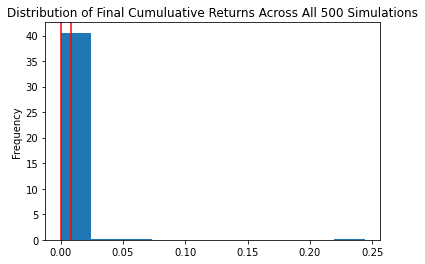

In [44]:
MC_n_years_new_allocation_original.plot_distribution()

In [45]:
MC_n_years_new_allocation_original.summarize_cumulative_return()

count           5.000000e+02
mean            1.691097e-03
std             1.168893e-02
min             9.618773e-07
25%             5.038594e-05
50%             1.864270e-04
75%             8.395896e-04
max             2.441551e-01
95% CI Lower    5.312259e-06
95% CI Upper    8.233224e-03
Name: 2520, dtype: float64

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

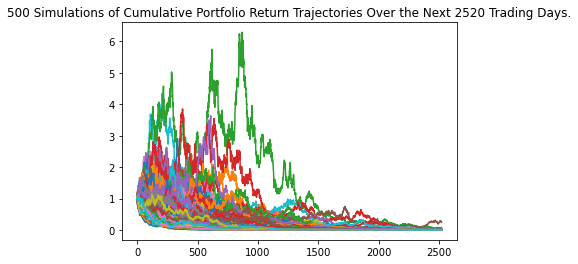

In [46]:
MC_n_years_new_allocation_original.plot_simulation()

In [47]:
# Optimized Portfolio Montecarlo Simulation
MC_n_years_optimized=MCSimulation(
    portfolio_data=all_results_df
    ,weights=list(optimal_portfolio_weights["Optimal Allocation"])
    ,num_simulation=500
    ,num_trading_days=252*int(report_df['years_until_retirement'][0])
)

In [48]:
MC_n_years_optimized.portfolio_data.head()

AGG               COIN                  SPY  \
                            close daily_return close daily_return   close   
time                                                                        
2008-01-02 05:00:00+00:00  101.65          NaN   NaN          NaN  144.55   
2008-01-03 05:00:00+00:00  101.72     0.000689   NaN          NaN  144.46   
2008-01-04 05:00:00+00:00  102.12     0.003932   NaN          NaN  140.93   
2008-01-07 05:00:00+00:00  102.26     0.001371   NaN          NaN  141.46   
2008-01-08 05:00:00+00:00  102.51     0.002445   NaN          NaN  138.81   

                                        
                          daily_return  
time                                    
2008-01-02 05:00:00+00:00          NaN  
2008-01-03 05:00:00+00:00    -0.000623  
2008-01-04 05:00:00+00:00    -0.024436  
2008-01-07 05:00:00+00:00     0.003761  
2008-01-08 05:00:00+00:00    -0.018733

In [49]:
MC_n_years_optimized.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992520,0.988000,1.001568,1.006082,0.985856,0.991160,0.995801,1.009287,1.007332,0.994663,...,1.014507,1.002480,0.997469,0.993081,1.003786,0.988331,1.016792,1.009443,0.998586,0.998813
2,0.988535,1.000738,1.015203,1.012069,0.996738,0.991341,1.002433,1.009677,0.992829,0.995954,...,1.024947,1.000245,0.994741,0.989014,1.004764,0.990035,1.013964,1.023520,0.992639,0.987422
3,0.986559,0.986213,1.000458,1.011226,1.001593,1.010092,1.013162,1.008336,0.992396,0.993669,...,1.025651,1.023400,0.990990,0.991754,1.017187,0.973361,1.003123,0.998739,1.003195,0.969768
4,0.991407,0.989790,1.015831,1.023484,1.009515,1.016865,1.011388,0.995185,0.984356,0.983835,...,1.024854,1.019865,0.985142,0.995911,1.002095,0.966183,1.005435,1.002685,1.027298,0.967940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.454673,0.882834,4.108316,2.549512,1.468780,2.747738,3.878476,2.100187,1.790627,2.759894,...,3.168902,1.081498,1.320797,1.812320,1.083473,1.310063,1.751130,1.797131,2.831237,2.760390
2517,2.472241,0.877747,4.113484,2.590216,1.516210,2.765542,3.866380,2.121649,1.779741,2.709268,...,3.157705,1.080557,1.312057,1.789710,1.069382,1.307981,1.738343,1.810617,2.817179,2.796781
2518,2.437809,0.871752,4.113160,2.577929,1.524748,2.827506,3.918248,2.135284,1.769980,2.738649,...,3.164806,1.089919,1.343449,1.786961,1.065277,1.303943,1.746627,1.817221,2.832769,2.789911
2519,2.445469,0.866814,4.154573,2.590692,1.539757,2.845593,3.892727,2.156498,1.780498,2.709022,...,3.162485,1.115226,1.350693,1.777598,1.079451,1.296249,1.710547,1.835380,2.820341,2.815539


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

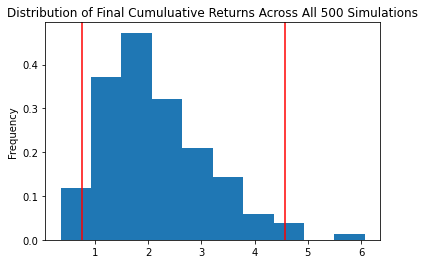

In [50]:
MC_n_years_optimized.plot_distribution() 

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

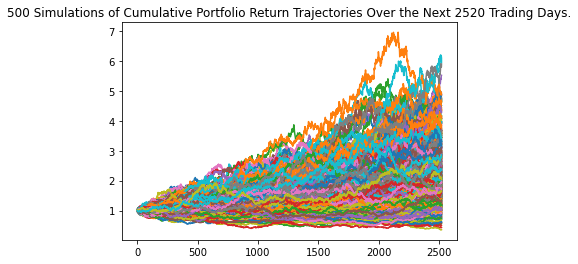

In [51]:
MC_n_years_optimized.plot_simulation()

In [52]:
MC_n_years_optimized.summarize_cumulative_return()

count           500.000000
mean              2.135892
std               0.988404
min               0.357249
25%               1.446985
50%               1.910874
75%               2.749410
max               6.071022
95% CI Lower      0.764418
95% CI Upper      4.571079
Name: 2520, dtype: float64

In [53]:
#Summary statistics result comparison
summary_statistics_combined=pd.concat([MC_n_years_new_allocation_original.summarize_cumulative_return(),MC_n_years_optimized.summarize_cumulative_return()]
          , axis=1)

summary_statistics_combined.columns=["Original","Optimized"]
round(summary_statistics_combined ,2)    

,Original,Optimized
count,500.00,500.00
mean,0.00,2.14
std,0.01,0.99
min,0.00,0.36
25%,0.00,1.45
50%,0.00,1.91
75%,0.00,2.75
max,0.24,6.07
95% CI Lower,0.00,0.76
95% CI Upper,0.01,4.57


In [54]:
# Calculating expected future amount
initial_investment=total_portfolio_value
final_investment=summary_statistics_combined.iloc[1:10,:]*initial_investment

# Apply money 
final_investment['Original']=final_investment['Original'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment['Optimized']=final_investment['Optimized'].apply(lambda x: "${:,.0f}k".format(x/1000))
final_investment

,Original,Optimized
mean,$0k,$5k
std,$0k,$2k
min,$0k,$1k
25%,$0k,$4k
50%,$0k,$5k
75%,$0k,$7k
max,$1k,$15k
95% CI Lower,$0k,$2k
95% CI Upper,$0k,$11k


# Future improvements: 
* Optimization: option to decrease variance, but keep original expected return.
* Montecarlo Simulation: include option for periodic contributions